In [1]:
import csv
from collections import defaultdict
from itertools import combinations
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib
from scipy.stats.contingency import odds_ratio

# Load data

In [180]:
# load data
attributes = ['ASD', 'noise', 'motor', 'sleep', 'gi', 'infections', 'verbal', 'vision', 'hearing', 
              'seizures', 'metabolic', 'premature']
attribute_to_index = dict([(x, i) for i, x in enumerate(attributes)])

comorbidities = ['Speech / Language Disorder', 
                 'Intellectual disability / global developmental delay', 
                 'Attention Deficit Hyperactivity Disorder (ADD/ADHD)',
                 'Oppositional Defiant / Conduct/ Disruptive Behavior Disorder',
                 'Specific learning disorder - reading',
                 'Specific learning disorder - math',
                 'Specific learning disorder - written expression',
                 'Anxiety',
                 'Motor / Developmental Coordination Disorder',
                 'Depression',
                 'Bipolar Disorder / Mania',
                 'Obsessive Compulsive Disorder (OCD)',
                 "Tic disorder / Tourette's",
                 'Feeding or eating disorder',
                 'Elimination Disorder']
comorbidity_to_abbrev = {
    'Speech / Language Disorder': 'SLD',
    'Intellectual disability / global developmental delay': 'ID'
}
comorbidity_to_index = dict([(x, i) for i, x in enumerate(comorbidities)])


class Child():
    def __init__(self, data, attribute_indices, comorbidity_indices, scq_indices):
        # basic info
        self.family = data[0]
        self.id = data[1]
        self.paternal = data[2]
        self.maternal = data[3]
        self.sex = data[4]
        self.age = None if data[5]=='' or int(data[5])<0 or int(data[5])>90 else int(data[5])
        self.asd = data[6]
        self.relatedness = data[7]
        self.group = data[20]
        
        # attributes
        self.attributes = [None if data[i]=='' else data[i] for i in attribute_indices]
        self.has_attributes_data = np.all([y is not None for y in self.attributes])
        
        # comorbidities
        self.has_comorbidities_data = data[21]=='yes'
        if self.has_comorbidities_data:
            self.comorbidities = [data[i]=='1' for i in comorbidity_indices]
        else:
            self.comorbidities = [None]*len(comorbidities)
        
        # SCQ
        self.SCQ = [None if data[i]=='' else data[i] for i in scq_indices]
        self.has_SCQ_data = np.any([y is not None for y in self.SCQ])
    

    def __str__(self):
        return 'Child(id=%s, fam=%s)' % (self.id, self.family)

fam_to_children = defaultdict(list)
children = []
attribute_indices = [None]*len(attributes)
comorbidity_indices = [None]*len(comorbidities)
scq_indices = [None]*40

with open('../data/kfExport_02-04-2023_fullSample_allColumns.csv', 'r') as f:
    reader = csv.reader(f)
    header = [x.strip() for x in next(reader)]
    
    for i, h in enumerate(header):
        if h in attributes:
            attribute_indices[attributes.index(h)] = i
        elif h in comorbidities:
            comorbidity_indices[comorbidities.index(h)] = i
        elif h.startswith('SCQ'):
            scq_indices[int(h.split()[1])-1] = i

    assert np.all([x is not None for x in attribute_indices])
    assert np.all([x is not None for x in comorbidity_indices])
    assert np.all([x is not None for x in scq_indices])
    
    for line in reader:
        child = Child(line, attribute_indices, comorbidity_indices, scq_indices)
        fam_to_children[child.family].append(child)
        children.append(child)
        
children_f = [x for x in children if x.sex=='female']
children_m = [x for x in children if x.sex=='male']

print('children', len(children), 'female', len(children_f), 'male', len(children_m))

children 6951 female 2318 male 4424


In [137]:
# Figure out what's in each column

# asd: yes/no
# premature: yes/no/missing=''
# sleep: yes/no/missing=''
# hearing: yes_hearingaids/yes_other/no/missing=''
# vision: yes/yes_other/no
# noise: yes_severe/yes_moderate/yes_mild/yes_other/yes_prefers/no/missing=''
# motor: yes/yes_some/no
# metabolic: yes/no/missing=''
# gi: yes/no/''
# infections: yes_constantly/yes_often/yes_slightly/no/missing=''
# seizures: yes/no/missing=''
# gestation: 23-40
# verbal: 1-10

print(set([x.attributes[attributes.index('seizures')] for x in children]))

{'no', 'yes', None}


In [138]:
print(children[0].sex)

female


# Association between attributes

In [139]:
print('children with attributes', len([x for x in children if x.has_attributes_data]))

children with attributes 5639


In [157]:
# This is how we determine whether an association exists between different combinations of attributes. 
# We do this using a chi-square test

X = np.ones((len(attributes), len(attributes)))
X_f = np.ones((len(attributes), len(attributes)))
X_m = np.ones((len(attributes), len(attributes)))

OR = np.zeros((len(attributes),))
OR_conf = np.zeros((len(attributes), 2))

# use all responses in chi2
def calculate_association(values_i, values_j):
    options_i = [y for y in set(values_i) if y is not None]
    options_j = [y for y in set(values_j) if y is not None]
    
    c = np.zeros((len(options_i), len(options_j)), dtype=int)
    for k, opt_i in enumerate(options_i):
        for l, opt_j in enumerate(options_j):
            c[k, l] = len([x for x, y in zip(values_i, values_j) if x==opt_i and y==opt_j])
    return c, stats.chi2_contingency(c)[:2]

def binarize_attribute(attr, values):
    if attr=='verbal':
        return [None if x is None else 'yes' if int(x)<=7 else 'no' for x in values]
    else:
        return [None if x is None else 'yes' if x!='no' else 'no' for x in values]

# categorical vs categorical with chi-squared test
num_tests = 0
for i, j in combinations(np.arange(len(attributes)), r=2):
    _, (_, p) = calculate_association([x.attributes[i] for x in children], 
                                 [x.attributes[j] for x in children])
    #p = compare_cat_as_bin(i, j, children)
    X[i, j] = p
    X[j, i] = p
    
    _, (_, p_f) = calculate_association([x.attributes[i] for x in children_f], 
                                 [x.attributes[j] for x in children_f])
    #p_f = compare_cat_as_bin(i, j, children_f)
    X_f[i, j] = p_f
    X_f[j, i] = p_f
    
    _, (_, p_m) = calculate_association([x.attributes[i] for x in children_m], 
                                 [x.attributes[j] for x in children_m])
    #p_m = compare_cat_as_bin(i, j, children_m)
    X_m[i, j] = p_m
    X_m[j, i] = p_m
    
    if attributes[i] == 'ASD':
        c, _ = calculate_association([x.attributes[i] for x in children],
                                     binarize_attribute(attributes[j], [x.attributes[j] for x in children]))
        res = odds_ratio(c)
        OR[j] = res.statistic
        OR_conf[j, 0] = res.confidence_interval(confidence_level=0.95).low
        OR_conf[j, 1] = res.confidence_interval(confidence_level=0.95).high
    
    num_tests += 1
    
for i in np.arange(len(attributes)):
    X[i, i] = calculate_association([x.attributes[i] for x in children], [x.attributes[i] for x in children])[1][1]
    X_f[i, i] = calculate_association([x.attributes[i] for x in children_f], [x.attributes[i] for x in children_f])[1][1]
    X_m[i, i] = calculate_association([x.attributes[i] for x in children_m], [x.attributes[i] for x in children_m])[1][1]


In [193]:
for i, attr in enumerate(attributes):
    print(attr,
          len([x for x in children if x.attributes[i]!='no' and x.asd=='yes' and x.has_attributes_data])/len([x for x in children if x.asd=='yes' and x.has_attributes_data]),
          len([x for x in children if x.attributes[i]!='no' and x.asd=='no' and x.has_attributes_data])/len([x for x in children if x.asd=='no' and x.has_attributes_data]),
                 sep='\t')

ASD	1.0	0.0
noise	0.48886664998749063	0.305115712545676
motor	0.3687765824368276	0.13885505481120586
sleep	0.37478108581436076	0.2046285018270402
gi	0.37052789592194146	0.14494518879415347
infections	0.1473605203902927	0.07856272838002436
verbal	1.0	1.0
vision	0.17563172379284464	0.20158343483556637
hearing	0.04553415061295972	0.03654080389768575
seizures	0.06129597197898424	0.030450669914738125
metabolic	0.03502626970227671	0.009135200974421437
premature	0.17087815861896422	0.14433617539585872


/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_60115/1776136023.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.clip(-np.log10(X_clipped*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))


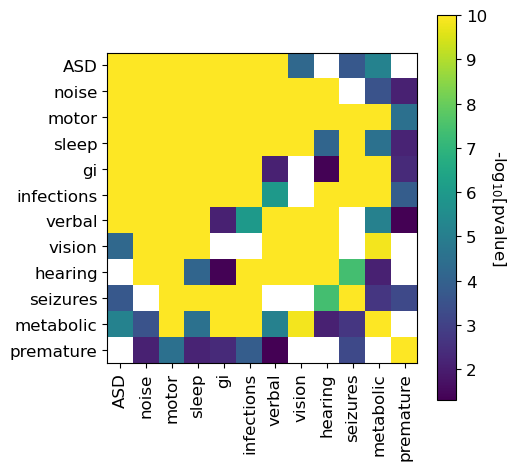

In [106]:
# Plot "correlation" between all pairs of attributes

X_clipped = X.copy()
X_clipped[X_clipped>0.05/num_tests] = np.nan
X_f_clipped = X_f.copy()
X_f_clipped[X_f_clipped>0.05/num_tests] = np.nan
X_m_clipped = X_m.copy()
X_m_clipped[X_m_clipped>0.05/num_tests] = np.nan

plt.figure(figsize=(5, 5))

plt.imshow(np.clip(-np.log10(X_clipped*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))
cbar = plt.colorbar(ticks=np.arange(11))
plt.xticks(range(len(attributes)), attributes, rotation=90, fontsize=12)
plt.yticks(range(len(attributes)), attributes, fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)

plt.show()

/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_60115/1305575034.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.clip(-np.log10(X_clipped), 0, 20))
/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_60115/1305575034.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.clip(-np.log10(X_f_clipped), 0, 20))
/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_60115/1305575034.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.clip(-np.log10(X_m_clipped), 0, 20))


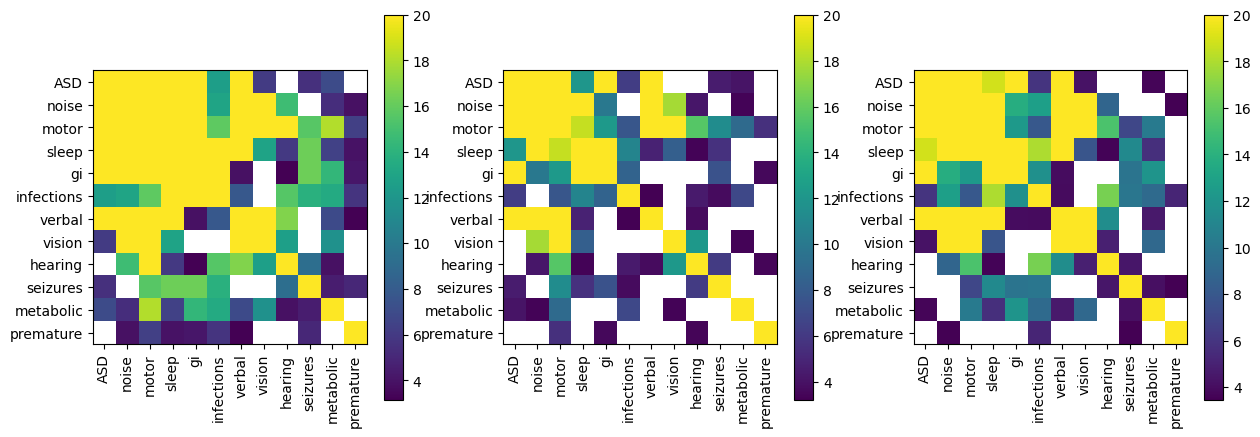

In [107]:
# Plot "correlation" between all pairs of attributes

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.clip(-np.log10(X_clipped), 0, 20))
plt.colorbar()
plt.xticks(range(len(attributes)), attributes, rotation=90)
plt.yticks(range(len(attributes)), attributes)

plt.subplot(1, 3, 2)
plt.imshow(np.clip(-np.log10(X_f_clipped), 0, 20))
plt.colorbar()
plt.xticks(range(len(attributes)), attributes, rotation=90)
plt.yticks(range(len(attributes)), attributes)

plt.subplot(1, 3, 3)
plt.imshow(np.clip(-np.log10(X_m_clipped), 0, 20))
plt.colorbar()
plt.xticks(range(len(attributes)), attributes, rotation=90)
plt.yticks(range(len(attributes)), attributes)
plt.show()

/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_60115/75847570.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.clip(-np.log10(X_f[0, :]), 0, 20), np.clip(-np.log10(X_m[0, :]), 0, 20))
/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_60115/75847570.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.text(np.clip(-np.log10(X_f[0, i]), 0, 20), np.clip(-np.log10(X_m[0, i]), 0, 20),


['premature']
['vision']


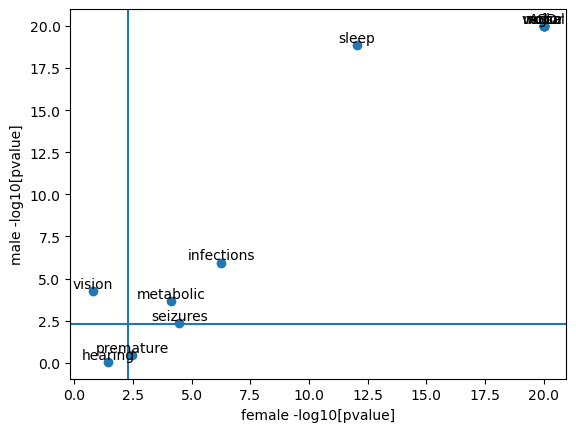

In [108]:
plt.scatter(np.clip(-np.log10(X_f[0, :]), 0, 20), np.clip(-np.log10(X_m[0, :]), 0, 20))
plt.axhline(-np.log10(0.05/10))
plt.axvline(-np.log10(0.05/10))

for i, attr in enumerate(attributes):
    plt.text(np.clip(-np.log10(X_f[0, i]), 0, 20), np.clip(-np.log10(X_m[0, i]), 0, 20), 
             attr, ha='center', va='bottom')
    

print([attributes[i] for i in np.where((X_f[0, :]<0.05/10) & (X_m[0, :]>0.05/10))[0]])
print([attributes[i] for i in np.where((X_f[0, :]>0.05/10) & (X_m[0, :]<0.05/10))[0]])
plt.xlabel('female -log10[pvalue]')
plt.ylabel('male -log10[pvalue]')

plt.show()

# Focus on correlation between autism status and each attribute

We might worry that family structure is distorting the correlations found above. So to take family structure out of
the equation, we'll try running a permutation test where we permute ASD status within families and then compare
the correlations we get with permuted data to the correlations we see in our actual data.

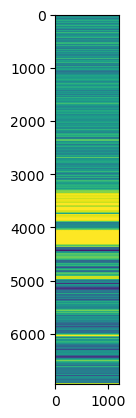

In [101]:
# First, we permute ASD status within families a bunch of times (12,000X)
# asd=1, nt=0

num_trials = 1200
permuted_asd_status = np.zeros((len(children), num_trials))
child_to_index = dict([(x.id, i) for i, x in enumerate(children)])

for fam, fam_children in fam_to_children.items():
    asd_status = [1 if child.asd=='yes' else 0 for child in fam_children]
    permuted_asd_status[[child_to_index[child.id] for child in fam_children], :] = np.array([random.sample(asd_status, k=len(asd_status)) for _ in range(num_trials)]).T

plt.imshow(permuted_asd_status)


In [111]:
# Now we compare the correlations we get when we look at the permuted data to the correlations we get when we
# look at the real data. This requires a lot of chi-squared tests so it takes a while to run.

# takes time to run due to permutations
permutation_pvalues = np.ones((len(attributes),))
chi2_pvalues = np.ones((len(attributes),))

for i, attr in enumerate(attributes):
    print(attr, end=' ')
    _, (s, p) = calculate_association([x.asd for x in children], [x.attributes[i] for x in children])
    chi2_pvalues[i] = p
    
    # estimate pvalues by permuting asd status within families
    num_over = 0
    for trial in range(num_trials):
        _, (perm_s, _) = calculate_association(permuted_asd_status[:, trial], [x.attributes[i] for x in children])
        num_over += int(np.abs(perm_s)>=np.abs(s))

    permutation_pvalues[i] = num_over/num_trials

ASD noise motor sleep gi infections verbal vision hearing seizures metabolic premature 

In [112]:
print(X[:, 0])
print(chi2_pvalues)

[0.00000000e+00 1.12950571e-73 2.62137436e-68 3.65819981e-35
 8.09698063e-63 2.39100585e-13 4.28384135e-82 8.44764868e-07
 2.65659724e-01 3.08318703e-06 1.04679784e-07 1.60098359e-02]
[0.00000000e+00 1.12950571e-73 2.62137436e-68 3.65819981e-35
 8.09698063e-63 2.39100585e-13 4.28384135e-82 8.44764868e-07
 2.65659724e-01 3.08318703e-06 1.04679784e-07 1.60098359e-02]


In [194]:
print('attr\t\tchi\t\tperm\tf\tm')
for i, a in enumerate(attributes):
    print(a[:6] + '\t', '%0.3e' % np.clip(chi2_pvalues[i]*(len(attributes)-1), 0, 1), 
          '%0.3f' % np.clip((len(attributes)-1)*permutation_pvalues[i], 0, 1), sep='\t')


attr		chi		perm	f	m
ASD		0.000e+00	0.000
noise		1.242e-72	0.000
motor		2.884e-67	0.000
sleep		4.024e-34	0.000
gi		8.907e-62	0.000
infect		2.630e-12	0.000
verbal		4.712e-81	0.000
vision		9.292e-06	0.037
hearin		1.000e+00	1.000
seizur		3.392e-05	0.000
metabo		1.151e-06	0.596
premat		1.761e-01	1.000


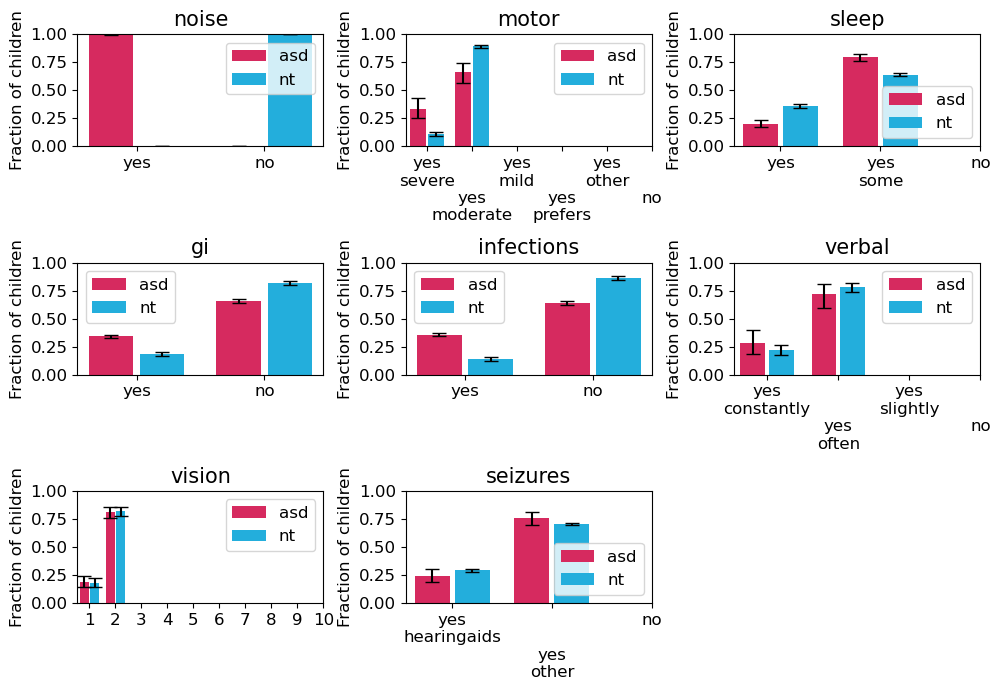

In [124]:
colors = ['#d62a5f', '#23aedc', '#d0bf4d', '#2d3594', '#d62a5f']

pvalues = permutation_pvalues

# plot results
plt.figure(figsize=(10, 7))

def plotbar(r, total, color, offset=0, label=None):
    p = r/total
    lb, ub = sm.stats.proportion_confint(r, total, alpha=0.05, method='agresti_coull')
    plt.bar(np.arange(len(r))+offset, p, width=0.35, label=label, color=color)
    plt.errorbar(np.arange(len(r))+offset, p, 
                 yerr=[p-lb, ub-p], 
                 color='black', linestyle='', capsize=5)

subplot_num = 1

ordered_responses = ['yes', 'yes_hearingaids', 'yes_severe', 'yes_constantly', 'yes_often', 'yes_moderate', 'yes_mild', 'yes_prefers', 'yes_other', 'yes_some', 'yes_slightly', 'no'] + list([str(x) for x in np.arange(11)])

for i, attr_i in enumerate(attributes[1:]):
    if pvalues[i+1]*len(attributes) < 0.05:
        c, _ = calculate_association([x.asd for x in children], [x.attributes[i] for x in children])

        plt.subplot(3, 3, subplot_num)
        subplot_num += 1
        plotbar(c[:, 0], np.sum(c[:, 0]), colors[0], label='asd')
        plotbar(c[:, 1], np.sum(c[:, 1]), colors[1], offset=0.4, label='nt')

        options_i = sorted([y for y in set([x.attributes[i] for x in children]) if y is not None], key=lambda x: ordered_responses.index(x))
        plt.title(attr_i, fontsize=15)
        if np.any([len(str(x))>10 for x in options_i]):
            plt.xticks(np.arange(len(options_i))+0.2, [('' if i%2==0 else '\n\n') + str(x).replace('_', '\n') for i, x in enumerate(options_i)], fontsize=12)
        else:
            plt.xticks(np.arange(len(options_i))+0.2, [str(x).replace('_', '\n') for x in options_i], fontsize=12)
        plt.ylim([0, 1])
        plt.yticks(fontsize=12)
        plt.ylabel('Fraction of children', fontsize=12)
        plt.legend(fontsize=12)
    

plt.tight_layout()
plt.show()

# Association between attributes and SCQ

In [141]:
print('children with SCQ', len([x for x in children if x.has_SCQ_data]))


children with SCQ 1512


In [174]:
X_scq = np.ones((len(attributes), 40))

OR_scq = np.zeros((40,))
OR_conf_scq = np.zeros((40, 2))
    
options_i = [True, False]
num_tests_scq = 0
for i in np.arange(40):
    for j, attr in enumerate(attributes):
        c, (_, p) = calculate_association([x.SCQ[i] for x in children], [x.attributes[j] for x in children])
        X_scq[j, i] = p
        
        if attr == 'ASD':
            res = odds_ratio(c)
            if res.statistic>1:
                OR_scq[i] = res.statistic
                OR_conf_scq[i, 0] = res.confidence_interval(confidence_level=0.95).low
                OR_conf_scq[i, 1] = res.confidence_interval(confidence_level=0.95).high
            else:
                c = c[[1, 0], :]
                res = odds_ratio(c)
                OR_scq[i] = res.statistic
                OR_conf_scq[i, 0] = res.confidence_interval(confidence_level=0.95).low
                OR_conf_scq[i, 1] = res.confidence_interval(confidence_level=0.95).high
        num_tests_scq +=1
            

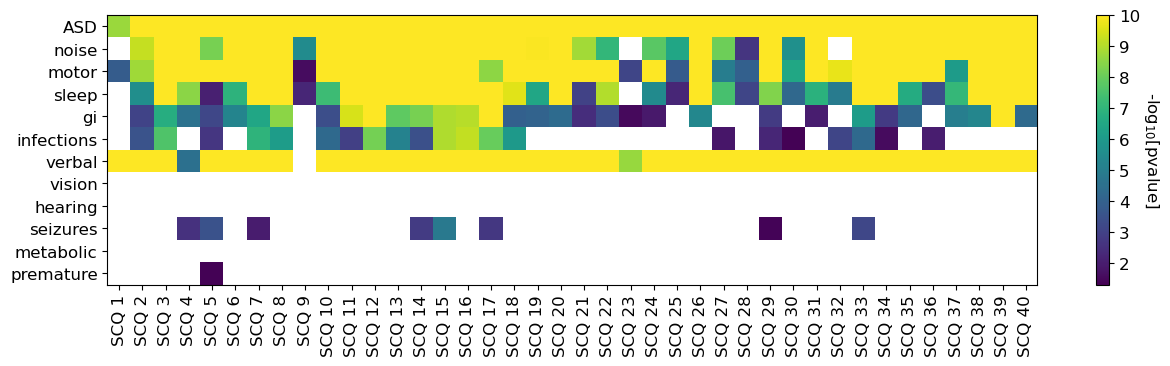

In [134]:
# Plot "correlation" between all pairs of attributes
plt.figure(figsize=(15, 3.5))

num_tests = (12*40)
X_scq[X_scq>0.05/num_tests] = np.nan

plt.imshow(np.clip(-np.log10(X_scq*num_tests_scq), 0, 10), vmax=10, vmin=-np.log10(0.05), aspect='auto')
cbar = plt.colorbar(ticks=np.arange(11))
plt.xticks(np.arange(40), ['SCQ %d' % (i+1) for i in range(40)], rotation=90, fontsize=12)
plt.yticks(range(len(attributes)), attributes, fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)
#plt.axvline(len(attrs)-0.5, color='black', linestyle='--')

plt.show()

# Look at comorbidities

In [142]:
print('children with comorbidities', len([x for x in children if x.has_comorbidities_data]))


children with comorbidities 3382


In [162]:
X_comorbid = np.ones((len(attributes), len(comorbidities)))

OR_comorbid = np.zeros((len(comorbidities),))
OR_conf_comorbid = np.zeros((len(comorbidities), 2))

print('Comorbidity\t', 'AUT\t\t\t', 'NT')
num_tests_comorbid = 0
for i, comorbid in enumerate(comorbidities):
    for j, attr in enumerate(attributes):
        c, (_, p) = calculate_association([x.comorbidities[i] for x in children], [x.attributes[j] for x in children])
        X_comorbid[j, i] = p
        
        if attr == 'ASD':
            res = odds_ratio(c)
            print(comorbid[:11], 
                  len([x for x in children if x.comorbidities[i] and x.asd=='yes'])/len([x for x in children if x.asd=='yes' and x.has_comorbidities_data]),
                  len([x for x in children if x.comorbidities[i] and x.asd=='no'])/len([x for x in children if x.asd=='no' and x.has_comorbidities_data]),
                 sep='\t')
            OR_comorbid[i] = res.statistic
            OR_conf_comorbid[i, 0] = res.confidence_interval(confidence_level=0.95).low
            OR_conf_comorbid[i, 1] = res.confidence_interval(confidence_level=0.95).high
        num_tests_comorbid += 1
        
        

Comorbidity	 AUT			 NT
Speech / La	0.3304448295782785	0.17686250757116898
Intellectua	0.17157712305025996	0.06541490006056935
Attention D	0.30791450028885037	0.26408237431859477
Oppositiona	0.05834777585210861	0.044215626892792244
Specific le	0.05025996533795494	0.06056935190793458
Specific le	0.03870595031773541	0.03391883706844337
Specific le	0.053726169844020795	0.039975772259236826
Anxiety	0.2368573079145003	0.20048455481526348
Motor / Dev	0.06932409012131716	0.03634161114476075
Depression	0.05950317735413056	0.06359781950333132
Bipolar Dis	0.01097631426920855	0.010902483343428226
Obsessive C	0.047949162333911034	0.01635372501514234
Tic disorde	0.01733102253032929	0.013325257419745608
Feeding or 	0.0560369728480647	0.027256208358570563
Elimination	0.015020219526285385	0.009085402786190187


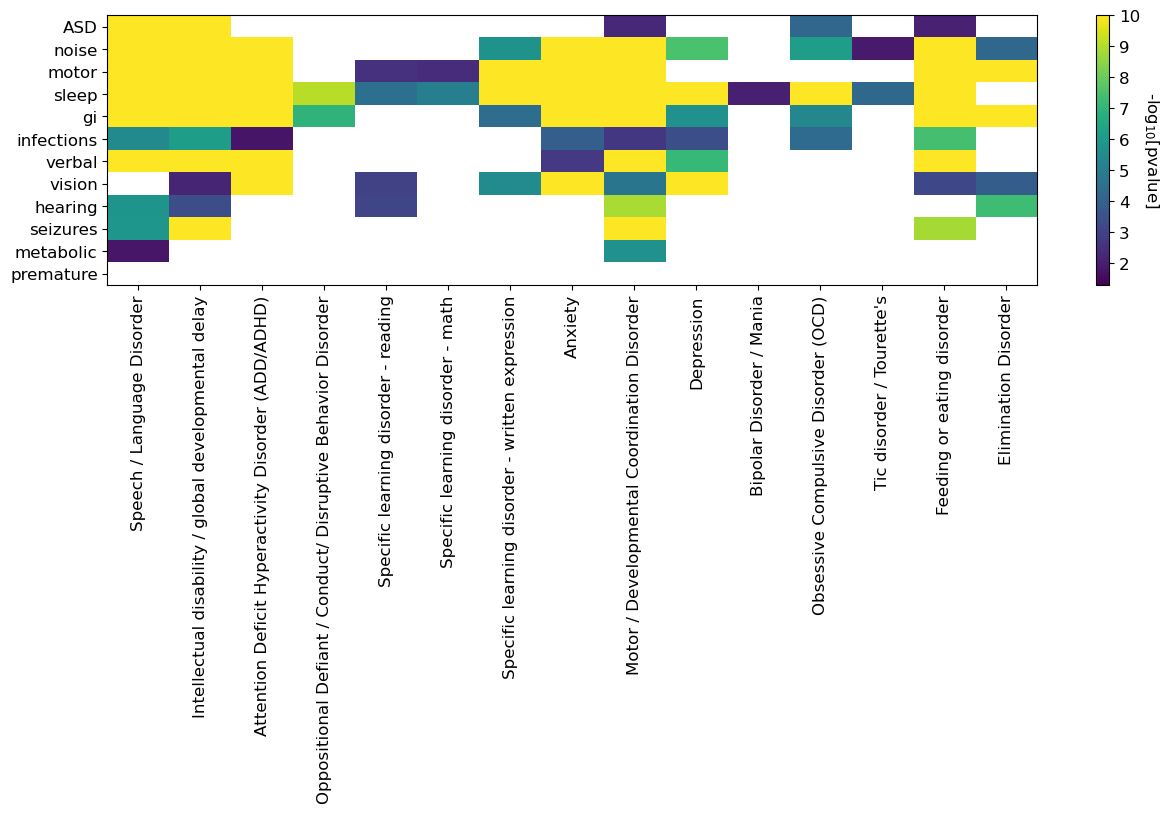

In [163]:
# Plot "correlation" between all pairs of attributes
plt.figure(figsize=(15, 3.5))

num_tests = (12*40)
X_comorbid[X_comorbid>0.05/num_tests] = np.nan

plt.imshow(np.clip(-np.log10(X_comorbid*num_tests_comorbid), 0, 10), vmax=10, vmin=-np.log10(0.05), aspect='auto')
cbar = plt.colorbar(ticks=np.arange(11))
plt.xticks(np.arange(len(comorbidities)), comorbidities, rotation=90, fontsize=12)
plt.yticks(range(len(attributes)), attributes, fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)
#plt.axvline(len(attrs)-0.5, color='black', linestyle='--')

plt.show()

# Compare comorbidities, attributes, and scq

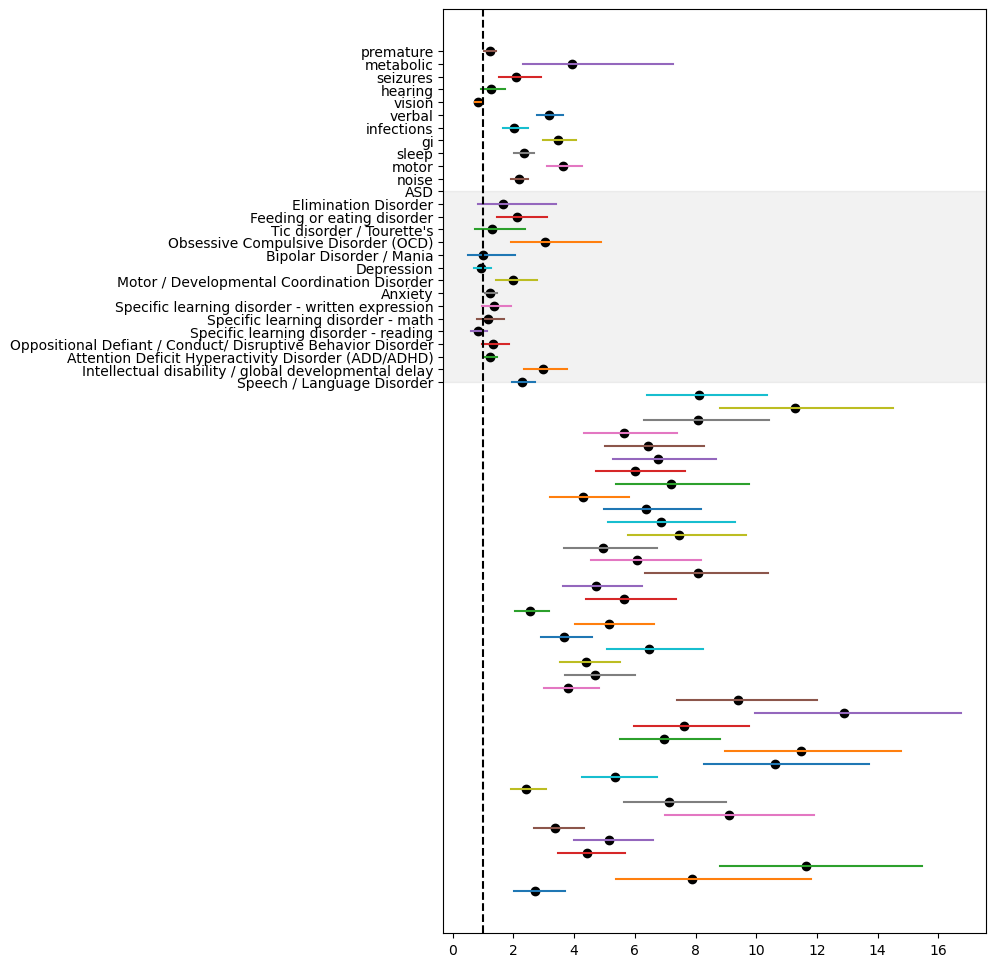

In [192]:
plt.figure(figsize=(7, 12))

for i in range(40):
    plt.plot(OR_conf_scq[i, :], [i, i])
    
for j, attr in enumerate(comorbidities):
    plt.plot(OR_conf_comorbid[j, :], [j+40, j+40])
    
for j, attr in enumerate(attributes):
    if j != 0:
        plt.plot(OR_conf[j, :], [j+40+len(comorbidities), j+40+len(comorbidities)])
        

plt.scatter(OR_scq, np.arange(40), color='black')
plt.scatter(OR_comorbid, np.arange(40, 40+len(comorbidities)), color='black')
plt.scatter(OR[1:], np.arange(40+len(comorbidities), 40+len(comorbidities)+len(attributes))[1:], color='black')

plt.yticks(np.arange(40, 40+len(comorbidities)+len(attributes)), comorbidities+attributes)

plt.axvline(1, color='black', linestyle='--')
plt.axhspan(40, 40+len(comorbidities), alpha=0.05, color='black')

#plt.xlim([0, 1])
plt.show()

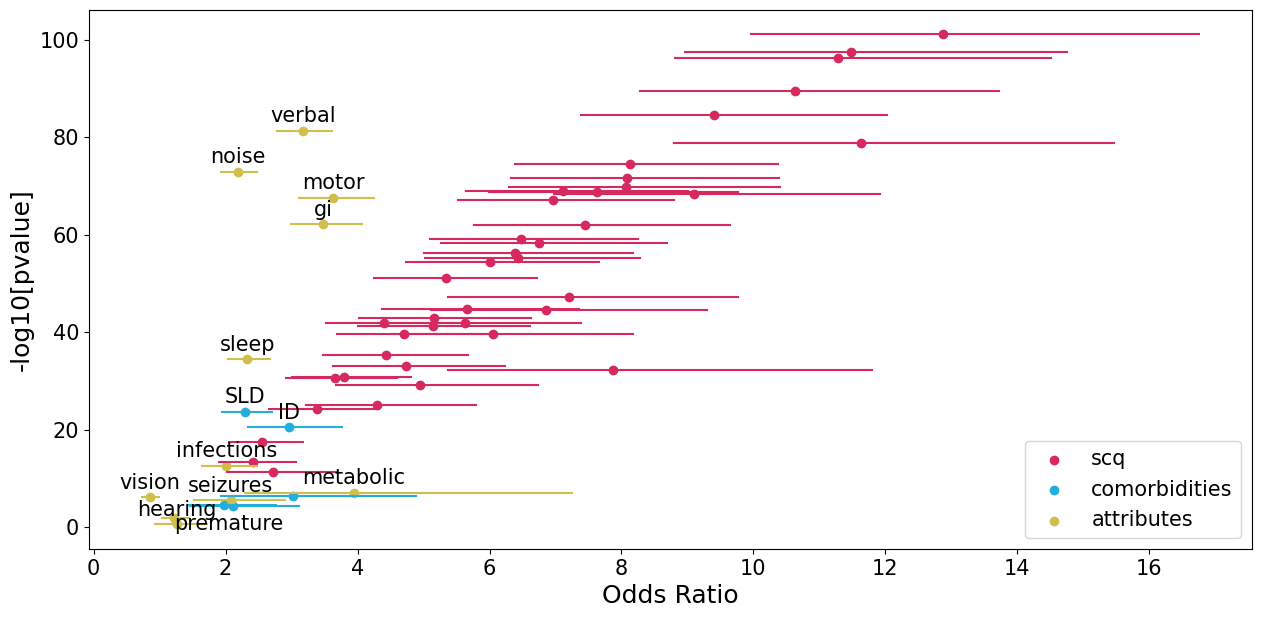

In [188]:
plt.figure(figsize=(15, 7))

for i in range(40):
    plt.plot(OR_conf_scq[i, :], -np.log10([X_scq[0, i], X_scq[0, i]]), color=colors[0])
    
for j, attr in enumerate(comorbidities):
    plt.plot(OR_conf_comorbid[j, :], -np.log10([X_comorbid[0, j], X_comorbid[0, j]]), color=colors[1])
    if -np.log10(X_comorbid[0, j])>10:
        plt.text(OR_comorbid[j], -np.log10(X_comorbid[0, j])+1, comorbidity_to_abbrev[attr], ha='center', va='bottom', fontsize=15)
    
for j, attr in enumerate(attributes):
    if j != 0:
        plt.plot(OR_conf[j, :], -np.log10([X[0, j], X[0, j]]), color=colors[2])
        if attr == 'premature':
            plt.text(OR[j], -np.log10(X[0, j])+1, attr, ha='left', va='top', fontsize=15)
            
        else:
            plt.text(OR[j], -np.log10(X[0, j])+1, attr, ha='center', va='bottom', fontsize=15)
        

plt.scatter(OR_scq, -np.log10(X_scq[0, :]), color=colors[0], label='scq')
plt.scatter(OR_comorbid, -np.log10(X_comorbid[0, :]), color=colors[1], label='comorbidities')
plt.scatter(OR[1:], -np.log10(X[0, 1:]), color=colors[2], label='attributes')

#plt.yticks(np.arange(40, 40+len(comorbidities)+len(attrs)), comorbidities+attrs)

#plt.axvline(1, color='black', linestyle='--')
#plt.axhspan(40, 40+len(comorbidities), alpha=0.05, color='black')

#plt.xlim([0, 1])
plt.xlabel('Odds Ratio', fontsize=18)
plt.ylabel('-log10[pvalue]', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

In [189]:
for i, attr in enumerate(attributes):
    print(attr, OR[i])

ASD 0.0
noise 2.183189549427213
motor 3.6271910324988874
sleep 2.3313377775482604
gi 3.4813885569271754
infections 2.011387796239211
verbal 3.1708902833038417
vision 0.8471243778567457
hearing 1.2587406129644036
seizures 2.0803768616019034
metabolic 3.941242999594306
premature 1.2215106104556743


# demographics

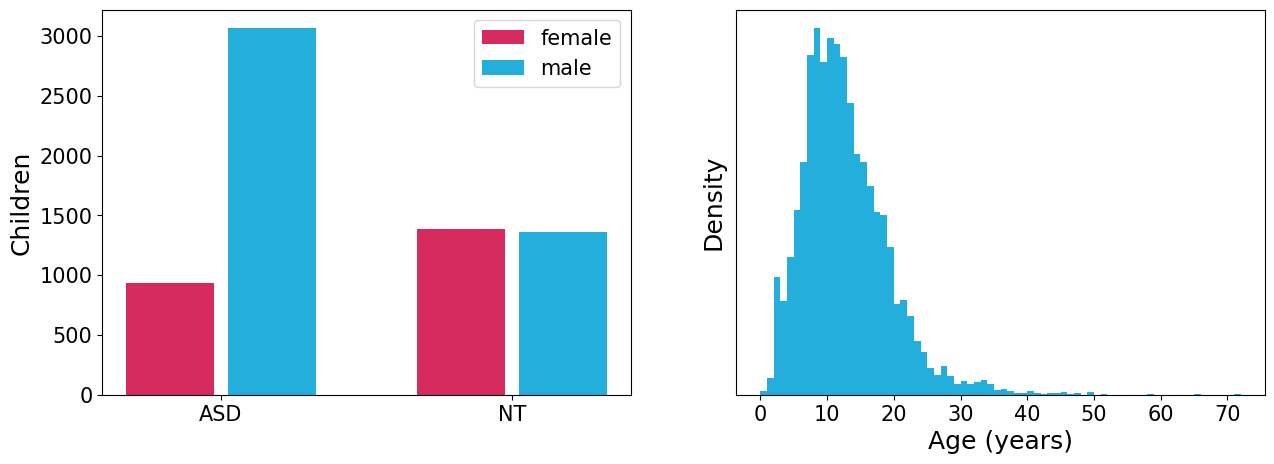

In [190]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(np.arange(2), [len([x for x in children if x.sex=='female' and x.asd=='yes']),
                       len([x for x in children if x.sex=='female' and x.asd=='no'])], 
        width=0.3, color=colors[0], label='female')
plt.bar(np.arange(2)+0.35, [len([x for x in children if x.sex=='male' and x.asd=='yes']),
                       len([x for x in children if x.sex=='male' and x.asd=='no'])], 
        width=0.3, color=colors[1], label='male')
plt.xticks([0.175, 1.175], ['ASD', 'NT'], fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.ylabel('Children', fontsize=18)

plt.subplot(1, 2, 2)
plt.hist([x.age for x in children if x.age is not None],
        bins=np.arange(0, 73), color=colors[1])
plt.xlabel('Age (years)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks([])

plt.show()

In [191]:
print(len([x for x in children if x.sex=='male' and x.asd=='yes'])/len([x for x in children if x.asd=='yes']))
print(np.max([x.age for x in children if x.age is not None]))
print(np.median([x.age for x in children if x.age is not None]))

0.7663668165917041
72
11.0
